# Oddstradamus
### Good odds and where to find them

### Modelling (Home)

Within this notebook, we finally get down to the modelling. As already mentioned, a total of 6 dataframes were prepared in this context to predict football matches in terms of the two-way outcome. In this notebook, 3 of the 6 dataframes are used to classify matches between home win and _double chance_ draw or away win. The aim is to develop a profitable long-term strategy that can beat the bookmaker in the long run. This includes the selection of suitable matches, the prediction of these matches and the determination of the optimal stake per match. The games have already been selected on the basis of the different data frames. Now it is a matter of finding out which data frame can achieve the best predictions. However, a high accuracy in connection with sports betting is not synonymous with a high profit. Since the latter is determined by the stake multiplied by the given betting odds. Let us briefly recall: The higher the probability of occurrence, the lower the odds and thus also the possible profit. Accordingly, the accuracy seems unsuitable for assessing the quality of the various machine learning algorithms. Therefore, we write our own metric without further ado, which takes this problem into account and reflects the profitability taking into account the stakes.

This notebook, after defining the metric, additionally includes the application of the following algorithms to all 3 dataframes:

| 1 Full-Dataframe | 2 50%-Dataframe | 3 Favorite-Dataframe |
| - | - | - |
| 1 Dummy Classifier | 1 Dummy Classifier | 1 Dummy Classifier |
| 2 Logistic Regression | 2 Logistic Regression | 2 Logistic Regression |
| 4 Logistic Regression (PCA) | 4 Logistic Regression (PCA) | 4 Logistic Regression (PCA) |
| 5 Support Vector Machine (PCA) | 5 Support Vector Machine (PCA) | 5 Support Vector Machine (PCA) |
| 6 Random Forest (PCA) | 6 Random Forest (PCA) | 6 Random Forest (PCA) |
| 7 Extra Trees (PCA) | 7 Extra Trees (PCA) | 7 Extra Trees (PCA) |
| 8 KNN (PCA) | 8 KNN (PCA) | 8 KNN (PCA) |
| 9 AdaBoost (PCA) | 9 AdaBoost (PCA) | 9 AdaBoost (PCA) |
| 10 XGBoost (PCA) | 10 XGBoost (PCA) | 10 XGBoost (PCA) |

For a better overview, the individual algorithms are numbered within the respective data frames. In the third step, a principal component analysis was performed. In addition, the more profitable metric per data frame is output within this notebook. Therefore, the first two data frames output the risk-averse profit and the last data frame the risk-averse profit.

In [1]:
# import packages
# basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from joblib import dump, load

# scikit-learn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

#settings
warnings.filterwarnings('ignore')

### Metric

As already announced, we are writing our own metric to evaluate our models. Basically, the metric calculates the profit if one were to bet all games according to the prediction of the respective model. If the prediction is correct, the stake is multiplied by the corresponding odds and credited to the _account balance_ (here: the profit variable). If the prediction is wrong, the entire stake is deducted from the _account balance_.

To determine the optimal stake, we have defined a risk-taking and a risk-averse variant. In the risk-taking variant, the stake per game is determined by the amount of the bet odds. For this purpose, the respective odds are converted into the probability of occurrence according to the known pattern ( 1 / odds). The probability of occurrence is then multiplied by the desired betting unit and the actual betting amount is obtained.
In the risk-averse variant, the average odds for a home win are also included in the multiplication, so that a second _certainty_ is included.

In [2]:
# defining the metrics

# risk-averse
def profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out, insert=1):
    profit = 0
    for i in range(len(actual)):
        if predicted[i] == '1':
            if actual[i] == predicted[i]:
                profit = profit + (((insert - (1/dc_odd[i])) * (1/avg_odd_fav[i])) * float(home_odd[i])) - ((insert - (1/dc_odd[i])) * (1/avg_odd_fav[i]))
            else:
                profit = profit - ((insert - (1/dc_odd[i])) * (1/avg_odd_fav[i]))
        if predicted[i] == 'X2':
            if actual [i] == predicted[i]:
                profit = profit + (((insert - (1/home_odd[i])) * (1/avg_odd_out[i])) * float(dc_odd[i])) - ((insert - (1/home_odd[i])) * (1/avg_odd_out[i]))
            else:
                profit = profit - ((insert - (1/home_odd[i])) * (1/avg_odd_out[i]))
    
    print(round(profit,2),'units in',len(actual),'games')    
                
    return print(round(profit / len(actual)*100, 2),'% gain per game')

# risk-taking
def profit_metric_fav(actual, predicted, home_odd, dc_odd, insert=1):
    profit = 0
    for i in range(len(actual)):
        if predicted[i] == '1':
            if actual[i] == predicted[i]:
                profit = profit + ((insert - (1/dc_odd[i])) * float((home_odd[i])) - (insert - (1/dc_odd[i])))
            else:
                profit = profit - (insert - (1/dc_odd[i]))
        if predicted[i] == 'X2':
            if actual [i] == predicted[i]:
                profit = profit + (insert - (1/home_odd[i])) * float((dc_odd[i])) - (insert - (1/home_odd[i]))
            else:
                profit = profit - (insert - (1/home_odd[i]))
    
    print(round(profit,2),'units in',len(actual),'games')    
                
    return print(round(profit / len(actual)*100, 2),'% gain per game')

## 1 Full Dataframe

In [3]:
# loading the dataframe
X_train_full = pd.read_csv('Data/model_home_csv/X_train_home_full.csv')
X_test_full = pd.read_csv('Data/model_home_csv/X_test_home_full.csv')
y_train_full = pd.read_csv('Data/model_home_csv/y_train_home_full.csv')
y_test_full = pd.read_csv('Data/model_home_csv/y_test_home_full.csv')
y_train_full = y_train_full['two_way_h_odd']
y_test_full = y_test_full['two_way_h_odd']

In [4]:
# assigning the variables of the profit metric
actual = y_test_full
home_odd = X_test_full.MaxHome
dc_odd = X_test_full.dc_away
avg_odd_fav = X_test_full.homewin_avg_odd
avg_odd_out = X_test_full.awaywin_avg_odd

#### 1.1 Dummy Classifier

In [5]:
# create a Dummy-Model
model_dummy_full = DummyClassifier(strategy = 'most_frequent')

In [6]:
# fit the model
model_dummy_full.fit(X_train_full, y_train_full)

DummyClassifier(strategy='most_frequent')

In [7]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_dummy_full = model_dummy_full.predict(X_test_full)
predicted = y_pred_dummy_full.tolist()

In [8]:
# print the classification report
print(classification_report(y_test_full, y_pred_dummy_full))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5553
          X2       0.56      1.00      0.72      7125

    accuracy                           0.56     12678
   macro avg       0.28      0.50      0.36     12678
weighted avg       0.32      0.56      0.40     12678



In [9]:
# print the result of the profit metric
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-143.59 units in 12678 games
-1.13 % gain per game


#### 1.2 Logistic Regression

In [10]:
# create a Logistic Regression Model / fit the model
logreg_full = LogisticRegression()
logreg_full.fit(X_train_full, y_train_full)

LogisticRegression()

In [11]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_full = logreg_full.predict(X_test_full)
predicted = y_pred_logreg_full.tolist()

In [12]:
# print the classification report
print(classification_report(y_test_full, y_pred_logreg_full))

              precision    recall  f1-score   support

           1       0.62      0.41      0.49      5553
          X2       0.64      0.80      0.71      7125

    accuracy                           0.63     12678
   macro avg       0.63      0.61      0.60     12678
weighted avg       0.63      0.63      0.61     12678



In [13]:
# print the result of the profit metric
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-73.9 units in 12678 games
-0.58 % gain per game


#### 1.3 Dimensionality Reduction

##### Data Scaling
PCA requires scaling/normalization of the data to work properly.

In [14]:
# assign the standard scaler
scaler = StandardScaler()

In [15]:
# scale train data with standard scaler
X_train_full_scaled = scaler.fit_transform(X_train_full)
df_full_scaled = pd.DataFrame(data=X_train_full_scaled,columns=X_train_full.columns)

##### Principal Componenent Analysis

In [16]:
# create a PCA object
pca_full = PCA(n_components=None)

In [17]:
# fit the PCA object
df_full_scaled_pca = pca_full.fit(df_full_scaled)

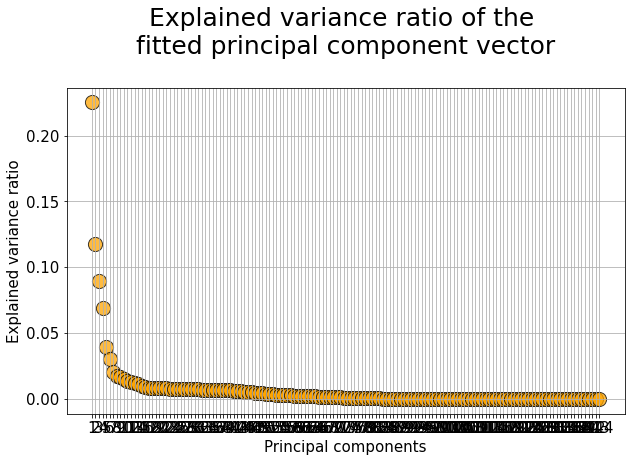

In [18]:
# plot the explained variance ratio for each principal component
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_full_scaled_pca.explained_variance_ratio_))],
            y=df_full_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_full_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [19]:
# transform the scaled data set using the fitted PCA object
X_train_full_scaled_trans = pca_full.transform(df_full_scaled)

In [20]:
# put it in a data frame
X_train_full_scaled_trans = pd.DataFrame(data=X_train_full_scaled_trans)

In [21]:
# assign the most meaningful variables
variables_full = [0,1,2,3,4,5,6]

#### 1.4 Logistic Regression (PCA)

In [22]:
# create a Logistic Regression Model / fit the model (PCA data)
logreg_full_pca = LogisticRegression()
logreg_full_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

LogisticRegression()

In [23]:
# scale test data with standard scaler / transform the scaled data set using the fitted PCA object
X_test_full_scaled = scaler.transform(X_test_full)
X_test_full_scaled_trans = pca_full.transform(X_test_full_scaled)

In [24]:
# put it in a data frame
X_test_full_scaled_trans = pd.DataFrame(data=X_test_full_scaled_trans)

In [25]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_full_pca = logreg_full_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])
predicted = y_pred_logreg_full_pca.tolist()

In [26]:
# print the classification report
print(classification_report(y_test_full, y_pred_logreg_full_pca))

              precision    recall  f1-score   support

           1       0.64      0.40      0.49      5553
          X2       0.64      0.83      0.72      7125

    accuracy                           0.64     12678
   macro avg       0.64      0.61      0.61     12678
weighted avg       0.64      0.64      0.62     12678



In [27]:
# print the result of the profit metric
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-92.81 units in 12678 games
-0.73 % gain per game


#### 1.5 Support Vector Machine (PCA)

In [28]:
# create a SVM-Model
model_full_svm_pca = SVC(kernel='linear', verbose = 1)

In [29]:
# fit the model (PCA)
model_full_svm_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

[LibSVM]

SVC(kernel='linear', verbose=1)

In [30]:
# predict the test data
y_pred_full_svm_pca = model_full_svm_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [31]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_svm_pca))

              precision    recall  f1-score   support

           1       0.72      0.22      0.34      5553
          X2       0.61      0.93      0.74      7125

    accuracy                           0.62     12678
   macro avg       0.66      0.58      0.54     12678
weighted avg       0.66      0.62      0.56     12678



In [32]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_svm_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-110.06 units in 12678 games
-0.87 % gain per game


#### 1.6 Random Forest (PCA)

In [33]:
# create a Random Forest-Model
model_full_rf_pca = RandomForestClassifier(n_estimators=120, 
                                           random_state=42, 
                                           max_features = 'sqrt',
                                           n_jobs=-1, verbose = 1)

In [34]:
# fit the model (PCA)
model_full_rf_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.5s finished


RandomForestClassifier(max_features='sqrt', n_estimators=120, n_jobs=-1,
                       random_state=42, verbose=1)

In [35]:
# predict the test data
y_pred_full_rf_pca = model_full_rf_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.1s finished


In [36]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_rf_pca))

              precision    recall  f1-score   support

           1       0.58      0.46      0.52      5553
          X2       0.64      0.74      0.69      7125

    accuracy                           0.62     12678
   macro avg       0.61      0.60      0.60     12678
weighted avg       0.61      0.62      0.61     12678



In [37]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_rf_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-90.82 units in 12678 games
-0.72 % gain per game


#### 1.7 Extra Trees (PCA)

In [38]:
# create a Extra Trees-Model
model_full_extra_pca = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [39]:
# fit the model (PCA)
model_full_extra_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

ExtraTreesClassifier(random_state=42)

In [40]:
# predict the test data
y_pred_full_extra_pca = model_full_extra_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [41]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_extra_pca))

              precision    recall  f1-score   support

           1       0.58      0.46      0.51      5553
          X2       0.64      0.75      0.69      7125

    accuracy                           0.62     12678
   macro avg       0.61      0.60      0.60     12678
weighted avg       0.62      0.62      0.61     12678



In [42]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_extra_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-83.51 units in 12678 games
-0.66 % gain per game


#### 1.8 KNN (PCA)

In [43]:
# create a KNN-Model
model_full_knn_pca = KNeighborsClassifier(n_neighbors=5, metric='minkowski', n_jobs=-1)

In [44]:
# fit the model (PCA)
model_full_knn_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

KNeighborsClassifier(n_jobs=-1)

In [45]:
# predict the test data
y_pred_full_knn_pca = model_full_knn_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [46]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_knn_pca))

              precision    recall  f1-score   support

           1       0.53      0.49      0.51      5553
          X2       0.62      0.66      0.64      7125

    accuracy                           0.59     12678
   macro avg       0.58      0.58      0.58     12678
weighted avg       0.58      0.59      0.58     12678



In [47]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_knn_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-91.57 units in 12678 games
-0.72 % gain per game


#### 1.9 AdaBoost (PCA)

In [48]:
# create a AdaBoost-Model
model_full_ada_pca = AdaBoostClassifier()

In [49]:
# fit the model (PCA)
model_full_ada_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

AdaBoostClassifier()

In [50]:
# predict the test data
y_pred_full_ada_pca = model_full_ada_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [51]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_ada_pca))

              precision    recall  f1-score   support

           1       0.63      0.41      0.50      5553
          X2       0.64      0.81      0.72      7125

    accuracy                           0.64     12678
   macro avg       0.64      0.61      0.61     12678
weighted avg       0.64      0.64      0.62     12678



In [52]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_ada_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-87.36 units in 12678 games
-0.69 % gain per game


#### 1.10 XGBoost (PCA)

In [53]:
# create a XGBoost-Model
model_full_xgb_pca = xgb.XGBClassifier()

In [54]:
# fit the model (PCA)
model_full_xgb_pca.fit(X_train_full_scaled_trans[variables_full], y_train_full)

[11:58:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
# predict the test data
y_pred_full_xgb_pca = model_full_xgb_pca.predict(X_test_full_scaled_trans[[0,1,2,3,4,5,6]])

In [56]:
# print the classification report
print(classification_report(y_test_full, y_pred_full_xgb_pca))

              precision    recall  f1-score   support

           1       0.59      0.45      0.51      5553
          X2       0.64      0.76      0.69      7125

    accuracy                           0.62     12678
   macro avg       0.62      0.60      0.60     12678
weighted avg       0.62      0.62      0.61     12678



In [57]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_full_xgb_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-89.25 units in 12678 games
-0.7 % gain per game


###  2 50%-Dataframe

In [58]:
# loading the dataframe
X_train_50 = pd.read_csv('Data/model_home_csv/X_train_home_50.csv')
X_test_50 = pd.read_csv('Data/model_home_csv/X_test_home_50.csv')
y_train_50 = pd.read_csv('Data/model_home_csv/y_train_home_50.csv')
y_test_50 = pd.read_csv('Data/model_home_csv/y_test_home_50.csv')
y_train_50 = y_train_50['two_way_h_odd']
y_test_50 = y_test_50['two_way_h_odd']

In [59]:
# assigning the variables of the profit metric
actual = y_test_50
home_odd = X_test_50.MaxHome
dc_odd = X_test_50.dc_away
avg_odd_fav = X_test_50.homewin_avg_odd
avg_odd_out = X_test_50.awaywin_avg_odd

#### 2.1 DummyClassifier

In [60]:
# create a Dummy-Model
model_50_dummy = DummyClassifier(strategy = 'most_frequent')

In [61]:
# fit the model
model_50_dummy.fit(X_train_50, y_train_50)

DummyClassifier(strategy='most_frequent')

In [62]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_50_dummy = model_50_dummy.predict(X_test_50)
predicted = y_pred_50_dummy.tolist()

In [63]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_dummy))

              precision    recall  f1-score   support

           1       0.64      1.00      0.78      2349
          X2       0.00      0.00      0.00      1304

    accuracy                           0.64      3653
   macro avg       0.32      0.50      0.39      3653
weighted avg       0.41      0.64      0.50      3653



In [64]:
# print the result of the profit metric
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

8.98 units in 3653 games
0.25 % gain per game


#### 2.2 Logistic Regression

In [65]:
# create a Logistic Regression-Model / fit the model
logreg_50 = LogisticRegression()
logreg_50.fit(X_train_50, y_train_50)

LogisticRegression()

In [66]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_50 = logreg_50.predict(X_test_50)
predicted = y_pred_logreg_50.tolist()

In [67]:
# print the classification report
print(classification_report(y_test_50, y_pred_logreg_50))

              precision    recall  f1-score   support

           1       0.64      0.98      0.78      2349
          X2       0.46      0.02      0.05      1304

    accuracy                           0.64      3653
   macro avg       0.55      0.50      0.41      3653
weighted avg       0.58      0.64      0.52      3653



In [68]:
# print the result of the profit metric
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

8.2 units in 3653 games
0.22 % gain per game


#### 2.3 Dimensionality Reduction

##### Data scaling
PCA requires scaling/normalization of the data to work properly.

In [69]:
# scale train data with standard scaler
X_train_50_scaled = scaler.fit_transform(X_train_50)
df_50_scaled = pd.DataFrame(data=X_train_50_scaled,columns=X_train_50.columns)

##### Dimensionality Reduction

In [70]:
# create a PCA object
pca_50 = PCA(n_components=None)

In [71]:
# fit the PCA object
df_50_scaled_pca = pca_50.fit(df_50_scaled)

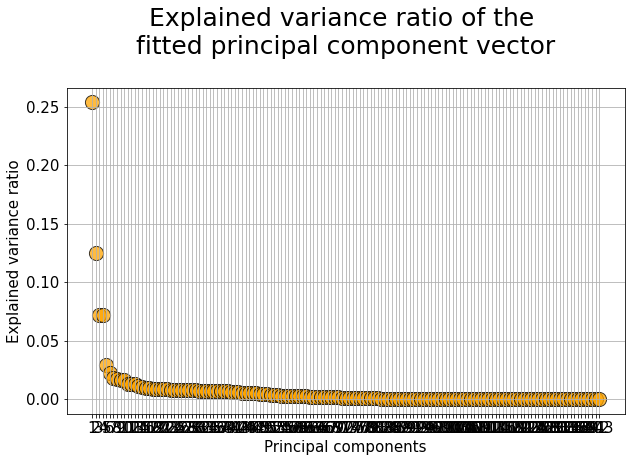

In [72]:
# plot the explained variance ratio for each principal component
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_50_scaled_pca.explained_variance_ratio_))],
            y=df_50_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_50_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [73]:
# transform the scaled data set using the fitted PCA object
X_train_50_scaled_trans = pca_50.transform(df_50_scaled)

##### Put it in a data frame

In [74]:
# put it in a data frame
X_train_50_scaled_trans = pd.DataFrame(data=X_train_50_scaled_trans)

In [75]:
# assign the most meaningful variables
variables_50 = [0,1,2,3,4,5,6]

#### 2.4 Logistic Regression (PCA)

In [76]:
# create a Logistic Regression-Model / fit the model (PCA)
logreg_50_pca = LogisticRegression()
logreg_50_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

LogisticRegression()

In [77]:
# scale test data with standard scaler / transform the scaled data set using the fitted PCA object
X_test_50_scaled = scaler.transform(X_test_50)
X_test_50_scaled_trans = pca_50.transform(X_test_50_scaled)

In [78]:
# put it in a data frame
X_test_50_scaled_trans = pd.DataFrame(data=X_test_50_scaled_trans)

In [79]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_50_pca = logreg_50_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])
predicted = y_pred_logreg_50_pca.tolist()

In [80]:
# print the classification report
print(classification_report(y_test_50, y_pred_logreg_50_pca))

              precision    recall  f1-score   support

           1       0.64      0.99      0.78      2349
          X2       0.30      0.01      0.01      1304

    accuracy                           0.64      3653
   macro avg       0.47      0.50      0.40      3653
weighted avg       0.52      0.64      0.51      3653



In [81]:
# print the result of the profit metric
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

6.51 units in 3653 games
0.18 % gain per game


#### 2.5 Support Vector Machine (PCA)

In [82]:
# create a SVM-Model
model_50_svm_pca = SVC(kernel='linear', verbose = 1)

In [83]:
# fit the model (PCA)
model_50_svm_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

[LibSVM]

SVC(kernel='linear', verbose=1)

In [84]:
# predict the test data
y_pred_50_svm_pca = model_50_svm_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [85]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_svm_pca))

              precision    recall  f1-score   support

           1       0.64      1.00      0.78      2349
          X2       0.00      0.00      0.00      1304

    accuracy                           0.64      3653
   macro avg       0.32      0.50      0.39      3653
weighted avg       0.41      0.64      0.50      3653



In [86]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_svm_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

8.98 units in 3653 games
0.25 % gain per game


#### 2.6 Random Forest (PCA)

In [87]:
# create a Random Forest-Model
model_50_rf = RandomForestClassifier(n_estimators=120, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [88]:
# fit the model (PCA)
model_50_rf.fit(X_train_50_scaled_trans[variables_50], y_train_50)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.9s finished


RandomForestClassifier(max_features='sqrt', n_estimators=120, n_jobs=-1,
                       random_state=42, verbose=1)

In [89]:
# predict the test data
y_pred_50_rf = model_50_rf.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.1s finished


In [90]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_rf))

              precision    recall  f1-score   support

           1       0.65      0.88      0.75      2349
          X2       0.41      0.15      0.23      1304

    accuracy                           0.62      3653
   macro avg       0.53      0.52      0.49      3653
weighted avg       0.57      0.62      0.56      3653



In [91]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_rf
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

0.34 units in 3653 games
0.01 % gain per game


#### 2.7 Extra Trees (PCA)

In [92]:
# create a Extra Trees-Model
model_50_extra_pca = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [93]:
# fit the model (PCA)
model_50_extra_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

ExtraTreesClassifier(random_state=42)

In [94]:
# predict the test data
y_pred_50_extra_pca = model_50_extra_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [95]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_extra_pca))

              precision    recall  f1-score   support

           1       0.65      0.89      0.75      2349
          X2       0.41      0.14      0.21      1304

    accuracy                           0.62      3653
   macro avg       0.53      0.51      0.48      3653
weighted avg       0.57      0.62      0.56      3653



In [96]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_extra_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

0.24 units in 3653 games
0.01 % gain per game


#### 2.8 KNN (PCA)

In [97]:
# create a KNN-Model
model_50_knn_pca = KNeighborsClassifier(n_neighbors=5, metric='minkowski', n_jobs=-1)

In [98]:
# fit the model (PCA)
model_50_knn_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

KNeighborsClassifier(n_jobs=-1)

In [99]:
# predict the test data
y_pred_50_knn_pca = model_50_knn_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [100]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_knn_pca))

              precision    recall  f1-score   support

           1       0.65      0.76      0.70      2349
          X2       0.39      0.27      0.32      1304

    accuracy                           0.59      3653
   macro avg       0.52      0.52      0.51      3653
weighted avg       0.56      0.59      0.57      3653



In [101]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_knn_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

-10.04 units in 3653 games
-0.27 % gain per game


#### 2.9 AdaBoost (PCA)

In [102]:
# create a AdaBoost-Model
model_50_ada_pca = AdaBoostClassifier()

In [103]:
# fit the model (PCA)
model_50_ada_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

AdaBoostClassifier()

In [104]:
# predict the test data
y_pred_50_ada_pca = model_50_ada_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [105]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_ada_pca))

              precision    recall  f1-score   support

           1       0.65      0.95      0.77      2349
          X2       0.46      0.08      0.14      1304

    accuracy                           0.64      3653
   macro avg       0.55      0.51      0.46      3653
weighted avg       0.58      0.64      0.55      3653



In [106]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_ada_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

8.09 units in 3653 games
0.22 % gain per game


#### 2.10 XGBoost (PCA)

In [107]:
# create a XGBoost-Model
model_50_xgb_pca = xgb.XGBClassifier()

In [108]:
# fit the model (PCA)
model_50_xgb_pca.fit(X_train_50_scaled_trans[variables_50], y_train_50)

[11:59:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
# predict the test data
y_pred_50_xgb_pca = model_50_xgb_pca.predict(X_test_50_scaled_trans[[0,1,2,3,4,5,6]])

In [110]:
# print the classification report
print(classification_report(y_test_50, y_pred_50_xgb_pca))

              precision    recall  f1-score   support

           1       0.66      0.82      0.73      2349
          X2       0.44      0.25      0.32      1304

    accuracy                           0.62      3653
   macro avg       0.55      0.53      0.52      3653
weighted avg       0.58      0.62      0.58      3653



In [111]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_50_xgb_pca
profit_metric(actual, predicted, home_odd, dc_odd, avg_odd_fav, avg_odd_out)

9.08 units in 3653 games
0.25 % gain per game


## 3 Favorite Dataframe

In [112]:
# loading the dataframe
X_train_fav = pd.read_csv('Data/model_home_csv/X_train_home_fav.csv')
X_test_fav = pd.read_csv('Data/model_home_csv/X_test_home_fav.csv')
y_train_fav = pd.read_csv('Data/model_home_csv/y_train_home_fav.csv')
y_test_fav = pd.read_csv('Data/model_home_csv/y_test_home_fav.csv')
y_train_fav = y_train_fav['two_way_h_odd']
y_test_fav = y_test_fav['two_way_h_odd']

In [113]:
# assigning the variables of the profit metric
actual = y_test_fav
home_odd = X_test_fav.MaxHome
dc_odd = X_test_fav.dc_away

#### 3.1 Dummy-Classifier

In [114]:
# create a Dummy-Model
model_dummy_fav = DummyClassifier(strategy = 'most_frequent')

In [115]:
# fit the model
model_dummy_fav.fit(X_train_fav, y_train_fav)

DummyClassifier(strategy='most_frequent')

In [116]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_dummy_fav = model_dummy_fav.predict(X_test_fav)
predicted = y_pred_dummy_fav.tolist()

In [117]:
# print the classification report
print(classification_report(y_test_fav, y_pred_dummy_fav))

              precision    recall  f1-score   support

           1       0.78      1.00      0.88       432
          X2       0.00      0.00      0.00       120

    accuracy                           0.78       552
   macro avg       0.39      0.50      0.44       552
weighted avg       0.61      0.78      0.69       552



In [118]:
# print the result of the profit metric
profit_metric_fav(actual, predicted, home_odd, dc_odd)

11.0 units in 552 games
1.99 % gain per game


#### 3.2 Logistic Regression

In [119]:
# create a Logistic Regression-Model
logreg_fav = LogisticRegression()

In [120]:
# fit the model
logreg_fav.fit(X_train_fav, y_train_fav)

LogisticRegression()

In [121]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_fav = logreg_fav.predict(X_test_fav)
predicted = y_pred_logreg_fav.tolist()

In [122]:
# print the classification report
print(classification_report(y_test_fav, y_pred_logreg_fav))

              precision    recall  f1-score   support

           1       0.80      0.98      0.88       432
          X2       0.64      0.12      0.20       120

    accuracy                           0.79       552
   macro avg       0.72      0.55      0.54       552
weighted avg       0.76      0.79      0.73       552



In [123]:
# print the result of the profit metric
profit_metric_fav(actual, predicted, home_odd, dc_odd)

14.02 units in 552 games
2.54 % gain per game


#### 3.3 Dimensionality Reduction

##### Data scaling
PCA requires scaling/normalization of the data to work properly.

In [124]:
# scale train data with standard scaler
X_train_fav_scaled = scaler.fit_transform(X_train_fav)
df_fav_scaled = pd.DataFrame(data=X_train_fav_scaled,columns=X_train_fav.columns)

##### Principal Component Analysis

In [125]:
# create a PCA object
pca_fav = PCA(n_components=None)

In [126]:
# fit the PCA object
df_fav_scaled_pca = pca_fav.fit(df_fav_scaled)

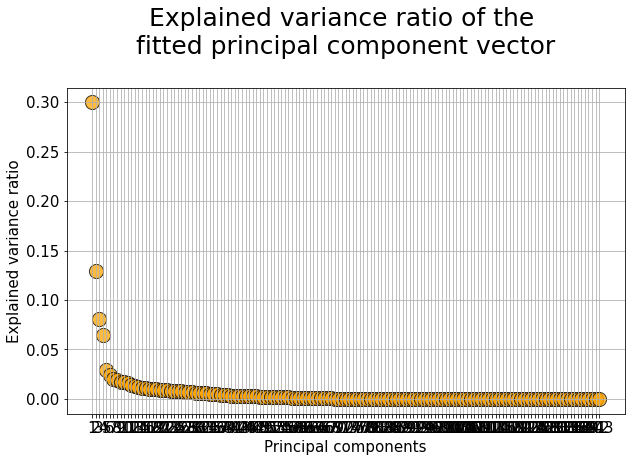

In [127]:
# plot the explained variance ratio for each principal component
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_fav_scaled_pca.explained_variance_ratio_))],
            y=df_fav_scaled_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_fav_scaled_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [128]:
# transform the scaled data set using the fitted PCA object
X_train_fav_scaled_trans = pca_fav.transform(df_fav_scaled)

In [129]:
# put it in a data frame
X_train_fav_scaled_trans = pd.DataFrame(data=X_train_fav_scaled_trans)

In [130]:
# assign the most meaningful variables
variables_fav = [0,1,2,3,4,5,6]

#### 3.4 Logistic Regression (PCA)

In [131]:
# create a Logistic Regression-Model / fit the model (PCA)
logreg_fav_pca = LogisticRegression()
logreg_fav_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

LogisticRegression()

In [132]:
# scale test data with standard scaler / transform the scaled data set using the fitted PCA object
X_test_fav_scaled = scaler.transform(X_test_fav)
X_test_fav_scaled_trans = pca_fav.transform(X_test_fav_scaled)

In [133]:
# put it in a data frame
X_test_fav_scaled_trans = pd.DataFrame(data=X_test_fav_scaled_trans)

In [134]:
# predict the test data / assign the predicted-variable for the profit metric
y_pred_logreg_fav_pca = logreg_fav_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])
predicted = y_pred_logreg_fav_pca.tolist()

In [135]:
# print the classification report
print(classification_report(y_test_fav, y_pred_logreg_fav_pca))

              precision    recall  f1-score   support

           1       0.80      0.97      0.88       432
          X2       0.56      0.12      0.19       120

    accuracy                           0.79       552
   macro avg       0.68      0.55      0.54       552
weighted avg       0.75      0.79      0.73       552



In [136]:
# print the result of the profit metric
profit_metric_fav(actual, predicted, home_odd, dc_odd)

9.39 units in 552 games
1.7 % gain per game


#### 3.5 Support Vector Machine (PCA)

In [137]:
# create a SVM-Model
model_fav_svm_pca = SVC(kernel='linear', verbose = 1)

In [138]:
# fit the model (PCA)
model_fav_svm_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

[LibSVM]

SVC(kernel='linear', verbose=1)

In [139]:
# predict the test data
y_pred_fav_svm_pca = model_fav_svm_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [140]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_svm_pca))

              precision    recall  f1-score   support

           1       0.78      1.00      0.88       432
          X2       0.00      0.00      0.00       120

    accuracy                           0.78       552
   macro avg       0.39      0.50      0.44       552
weighted avg       0.61      0.78      0.69       552



In [141]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_svm_pca
profit_metric_fav(actual, predicted, home_odd, dc_odd)

11.0 units in 552 games
1.99 % gain per game


#### 3.6 Random Forest (PCA)

In [142]:
# create a Random Forest-Model
model_fav_rf = RandomForestClassifier(n_estimators=120, 
                                      random_state=42, 
                                      max_features = 'sqrt',
                                      n_jobs=-1, verbose = 1)

In [143]:
# fit the model (PCA)
model_fav_rf.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


RandomForestClassifier(max_features='sqrt', n_estimators=120, n_jobs=-1,
                       random_state=42, verbose=1)

In [144]:
# predict the test data
y_pred_fav_rf = model_fav_rf.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished


In [145]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_rf))

              precision    recall  f1-score   support

           1       0.80      0.97      0.88       432
          X2       0.58      0.15      0.24       120

    accuracy                           0.79       552
   macro avg       0.69      0.56      0.56       552
weighted avg       0.76      0.79      0.74       552



In [146]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_rf
profit_metric_fav(actual, predicted, home_odd, dc_odd)

13.08 units in 552 games
2.37 % gain per game


#### 3.7 Extra Trees (PCA)

In [147]:
# create a Extra Trees-Model
model_fav_extra_pca = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [148]:
# fit the model (PCA)
model_fav_extra_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

ExtraTreesClassifier(random_state=42)

In [149]:
# predict the test data
y_pred_fav_extra_pca = model_fav_extra_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [150]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_extra_pca))

              precision    recall  f1-score   support

           1       0.80      0.98      0.88       432
          X2       0.64      0.12      0.20       120

    accuracy                           0.79       552
   macro avg       0.72      0.55      0.54       552
weighted avg       0.76      0.79      0.73       552



In [151]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_extra_pca
profit_metric_fav(actual, predicted, home_odd, dc_odd)

13.82 units in 552 games
2.5 % gain per game


#### 3.8 KNN (PCA)

In [152]:
# create a KNN-Model
model_fav_knn_pca = KNeighborsClassifier(n_neighbors=5, metric='minkowski', n_jobs=-1)

In [153]:
# fit the model (PCA)
model_fav_knn_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

KNeighborsClassifier(n_jobs=-1)

In [154]:
# predict the test data
y_pred_fav_knn_pca = model_fav_knn_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [155]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_knn_pca))

              precision    recall  f1-score   support

           1       0.81      0.93      0.87       432
          X2       0.46      0.21      0.29       120

    accuracy                           0.78       552
   macro avg       0.64      0.57      0.58       552
weighted avg       0.73      0.78      0.74       552



In [156]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_knn_pca
profit_metric_fav(actual, predicted, home_odd, dc_odd)

16.48 units in 552 games
2.98 % gain per game


#### 3.9 AdaBoost (PCA)

In [157]:
# create a AdaBoost-Model
model_fav_ada_pca = AdaBoostClassifier()

In [158]:
# fit the model (PCA)
model_fav_ada_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

AdaBoostClassifier()

In [159]:
# predict the test data
y_pred_fav_ada_pca = model_fav_ada_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [160]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_ada_pca))

              precision    recall  f1-score   support

           1       0.81      0.95      0.87       432
          X2       0.50      0.18      0.27       120

    accuracy                           0.78       552
   macro avg       0.65      0.57      0.57       552
weighted avg       0.74      0.78      0.74       552



In [161]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_ada_pca
profit_metric_fav(actual, predicted, home_odd, dc_odd)

12.67 units in 552 games
2.29 % gain per game


#### 3.10 XGBoost (PCA)

In [162]:
# create a XGBoost-Model
model_fav_xgb_pca = xgb.XGBClassifier()

In [163]:
# fit the model (PCA)
model_fav_xgb_pca.fit(X_train_fav_scaled_trans[variables_fav], y_train_fav)

[11:59:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [164]:
# predict the test data
y_pred_fav_xgb_pca = model_fav_xgb_pca.predict(X_test_fav_scaled_trans[[0,1,2,3,4,5,6]])

In [165]:
# print the classification report
print(classification_report(y_test_fav, y_pred_fav_xgb_pca))

              precision    recall  f1-score   support

           1       0.81      0.93      0.86       432
          X2       0.45      0.21      0.28       120

    accuracy                           0.77       552
   macro avg       0.63      0.57      0.57       552
weighted avg       0.73      0.77      0.74       552



In [166]:
# assign the predicted-variable for the profit metric / print the result of the profit metric
predicted = y_pred_fav_xgb_pca
profit_metric_fav(actual, predicted, home_odd, dc_odd)

14.55 units in 552 games
2.64 % gain per game
